# AnnoMI Advanced Modeling - Therapy Dynamics & Human Behavior

This notebook implements advanced analyses to understand therapy processes and human behavioral patterns.

**Analyses Included:**
1. 🔄 **Cognitive Synchrony Analysis** - Therapist-client alignment over time
2. 🎯 **Change Talk Prediction** - Predicting client commitment from cognitive patterns
3. 🔍 **Critical Moment Detection** - Identifying breakthrough and stuck points
4. 👥 **Therapist Style Profiling** - Clustering therapists by cognitive strategies
5. 📈 **Sequential Pattern Modeling** - Markov chains for conversation flow
6. 🕸️ **Network Analysis** - Graph-based insights into cognitive action relationships

**Requirements:**
- Pre-computed predictions from `all_predictions.json`

## Setup and Data Loading

In [33]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import combinations
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("✅ Libraries loaded")

✅ Libraries loaded


In [34]:
# Load predictions
predictions_path = 'output/analysis_AnnoMI/all_predictions.json'

print("📥 Loading predictions...")
with open(predictions_path, 'r') as f:
    all_predictions = json.load(f)

# Create DataFrame
df = pd.DataFrame(all_predictions)

# Filter short utterances
MIN_LENGTH = 10
df['utterance_length'] = df['utterance_text'].str.len()
df = df[df['utterance_length'] >= MIN_LENGTH].copy()

print(f"✅ Loaded {len(df)} utterances (filtered)")

# Extract active actions
def extract_active_actions(predictions_dict):
    active = []
    for action, data in predictions_dict.items():
        if data.get('is_active', False):
            active.append({
                'action': action,
                'confidence': data['aggregate'],
                'best_layer': data['best_layer']
            })
    return active

df['active_actions'] = df['predictions'].apply(extract_active_actions)
df['num_active_actions'] = df['active_actions'].apply(len)
df['action_names'] = df['active_actions'].apply(lambda x: [a['action'] for a in x])

# Get all unique actions
all_actions = sorted(set(
    action for actions in df['action_names'] for action in actions
))

print(f"   Unique cognitive actions: {len(all_actions)}")
print(f"   Transcripts: {df['transcript_id'].nunique()}")
print(f"   Topics: {df['topic'].nunique()}")

📥 Loading predictions...
✅ Loaded 7372 utterances (filtered)
   Unique cognitive actions: 45
   Transcripts: 133
   Topics: 44


## 0️⃣.1 Filter High-Confidence Cognitive Actions

Filter predictions to keep only cognitive actions that:
- Appear on **more than 2 layers**, OR
- Have **100% confidence score**

This removes noise and focuses on robust cognitive action detections.

In [35]:
print("🔍 Filtering cognitive actions for high confidence...")
print(f"   Total predictions before filtering: {len(all_predictions)}")

# Filter each prediction to keep only high-confidence actions
filtered_predictions_list = []

for pred_data in all_predictions:
    action_layer_details = pred_data.get('action_layer_details', {})
    predictions = pred_data['predictions']
    
    # Create filtered predictions dict
    filtered_predictions = {}
    
    for action_name, action_info in predictions.items():
        if not action_info.get('is_active', False):
            continue
        
        # Check filtering criteria
        num_layers = len(action_layer_details.get(action_name, []))
        max_confidence = max([layer_info['confidence'] for layer_info in action_layer_details.get(action_name, [])], default=0)
        
        # Keep if: appears on >2 layers OR has 100% confidence
        if num_layers > 2 or max_confidence >= 1.0:
            filtered_predictions[action_name] = action_info
    
    # Create filtered prediction entry
    filtered_pred_data = pred_data.copy()
    filtered_pred_data['predictions'] = filtered_predictions
    filtered_predictions_list.append(filtered_pred_data)

# Count statistics
total_actions_before = sum(len([a for a, d in pred['predictions'].items() if d.get('is_active', False)]) 
                          for pred in all_predictions)
total_actions_after = sum(len([a for a, d in pred['predictions'].items() if d.get('is_active', False)]) 
                         for pred in filtered_predictions_list)

print(f"   Total predictions after filtering: {len(filtered_predictions_list)}")
print(f"   Active actions before: {total_actions_before}")
print(f"   Active actions after: {total_actions_after}")
print(f"   Removed: {total_actions_before - total_actions_after} actions ({(total_actions_before - total_actions_after)/total_actions_before*100:.1f}%)")

# Replace all_predictions with filtered version
all_predictions = filtered_predictions_list

# Recreate DataFrame with filtered data
df = pd.DataFrame(all_predictions)
df['utterance_length'] = df['utterance_text'].str.len()
df = df[df['utterance_length'] >= MIN_LENGTH].copy()

# Re-extract active actions from filtered predictions
def extract_active_actions(predictions_dict):
    active = []
    for action, data in predictions_dict.items():
        if data.get('is_active', False):
            active.append({
                'action': action,
                'confidence': data['aggregate'],
                'best_layer': data['best_layer']
            })
    return active

df['active_actions'] = df['predictions'].apply(extract_active_actions)
df['num_active_actions'] = df['active_actions'].apply(len)
df['action_names'] = df['active_actions'].apply(lambda x: [a['action'] for a in x])

# Get all unique actions (from filtered data)
all_actions = sorted(set(
    action for actions in df['action_names'] for action in actions
))

print(f"✅ Filtering complete! Using {len(df)} filtered predictions for all analyses.")
print(f"   Unique cognitive actions after filtering: {len(all_actions)}")

🔍 Filtering cognitive actions for high confidence...
   Total predictions before filtering: 9699
   Total predictions after filtering: 9699
   Active actions before: 62355
   Active actions after: 40228
   Removed: 22127 actions (35.5%)
✅ Filtering complete! Using 7372 filtered predictions for all analyses.
   Unique cognitive actions after filtering: 45


## 1️⃣ Cognitive Synchrony Analysis

Measure alignment between therapist and client cognitive patterns over time.

In [36]:
print("="*80)
print("COGNITIVE SYNCHRONY ANALYSIS")
print("="*80)

# Create cognitive action vectors for each utterance
def create_action_vector(action_names, all_actions):
    """Create binary vector for cognitive actions"""
    vector = np.zeros(len(all_actions))
    for action in action_names:
        if action in all_actions:
            idx = all_actions.index(action)
            vector[idx] = 1
    return vector

df['action_vector'] = df['action_names'].apply(
    lambda x: create_action_vector(x, all_actions)
)

# Calculate synchrony for each transcript
def calculate_synchrony(transcript_df, window_size=5):
    """
    Calculate cognitive synchrony between therapist and client.
    Uses sliding window to compute cosine similarity.
    """
    therapist_vectors = []
    client_vectors = []
    positions = []
    
    for i in range(len(transcript_df) - window_size + 1):
        window = transcript_df.iloc[i:i+window_size]
        
        t_vecs = [v for v, interlocutor in zip(window['action_vector'], window['interlocutor']) 
                  if interlocutor == 'therapist']
        c_vecs = [v for v, interlocutor in zip(window['action_vector'], window['interlocutor']) 
                  if interlocutor == 'client']
        
        if len(t_vecs) > 0 and len(c_vecs) > 0:
            # Average vectors in window
            t_avg = np.mean(t_vecs, axis=0)
            c_avg = np.mean(c_vecs, axis=0)
            
            # Cosine similarity
            norm_t = np.linalg.norm(t_avg)
            norm_c = np.linalg.norm(c_avg)
            
            if norm_t > 0 and norm_c > 0:
                similarity = np.dot(t_avg, c_avg) / (norm_t * norm_c)
                therapist_vectors.append(t_avg)
                client_vectors.append(c_avg)
                positions.append(i / len(transcript_df))  # Normalized position
    
    return positions, therapist_vectors, client_vectors

# Compute synchrony for each transcript
synchrony_results = []

for transcript_id in df['transcript_id'].unique():
    transcript_df = df[df['transcript_id'] == transcript_id].sort_values('utterance_id')
    
    if len(transcript_df) < 10:  # Skip very short transcripts
        continue
    
    positions, t_vecs, c_vecs = calculate_synchrony(transcript_df, window_size=5)
    
    if len(positions) > 0:
        # Calculate synchrony scores
        synchrony_scores = []
        for t_vec, c_vec in zip(t_vecs, c_vecs):
            norm_t = np.linalg.norm(t_vec)
            norm_c = np.linalg.norm(c_vec)
            if norm_t > 0 and norm_c > 0:
                similarity = np.dot(t_vec, c_vec) / (norm_t * norm_c)
                synchrony_scores.append(similarity)
        
        mi_quality = transcript_df['mi_quality'].iloc[0]
        topic = transcript_df['topic'].iloc[0]
        
        synchrony_results.append({
            'transcript_id': transcript_id,
            'mi_quality': mi_quality,
            'topic': topic,
            'positions': positions,
            'synchrony_scores': synchrony_scores,
            'mean_synchrony': np.mean(synchrony_scores),
            'synchrony_trend': np.polyfit(positions, synchrony_scores, 1)[0]  # Linear trend
        })

print(f"\n✅ Analyzed {len(synchrony_results)} transcripts")

# Compare by MI quality
high_quality_sync = [r['mean_synchrony'] for r in synchrony_results if r['mi_quality'] == 'high']
low_quality_sync = [r['mean_synchrony'] for r in synchrony_results if r['mi_quality'] == 'low']

print(f"\n📊 Mean Cognitive Synchrony:")
print(f"   High quality MI: {np.mean(high_quality_sync):.3f} (±{np.std(high_quality_sync):.3f})")
print(f"   Low quality MI:  {np.mean(low_quality_sync):.3f} (±{np.std(low_quality_sync):.3f})")

# Statistical test
if len(high_quality_sync) > 0 and len(low_quality_sync) > 0:
    t_stat, p_val = stats.ttest_ind(high_quality_sync, low_quality_sync)
    print(f"   t-test: t={t_stat:.3f}, p={p_val:.4f}")
    if p_val < 0.05:
        print(f"   ✅ Significant difference in synchrony by MI quality!")

# Analyze trends
high_quality_trend = [r['synchrony_trend'] for r in synchrony_results if r['mi_quality'] == 'high']
low_quality_trend = [r['synchrony_trend'] for r in synchrony_results if r['mi_quality'] == 'low']

print(f"\n📈 Synchrony Trend (change over session):")
print(f"   High quality MI: {np.mean(high_quality_trend):.4f} (positive = increasing synchrony)")
print(f"   Low quality MI:  {np.mean(low_quality_trend):.4f}")

COGNITIVE SYNCHRONY ANALYSIS

✅ Analyzed 129 transcripts

📊 Mean Cognitive Synchrony:
   High quality MI: 0.385 (±0.067)
   Low quality MI:  0.422 (±0.091)
   t-test: t=-2.121, p=0.0359
   ✅ Significant difference in synchrony by MI quality!

📈 Synchrony Trend (change over session):
   High quality MI: -0.0531 (positive = increasing synchrony)
   Low quality MI:  0.0686


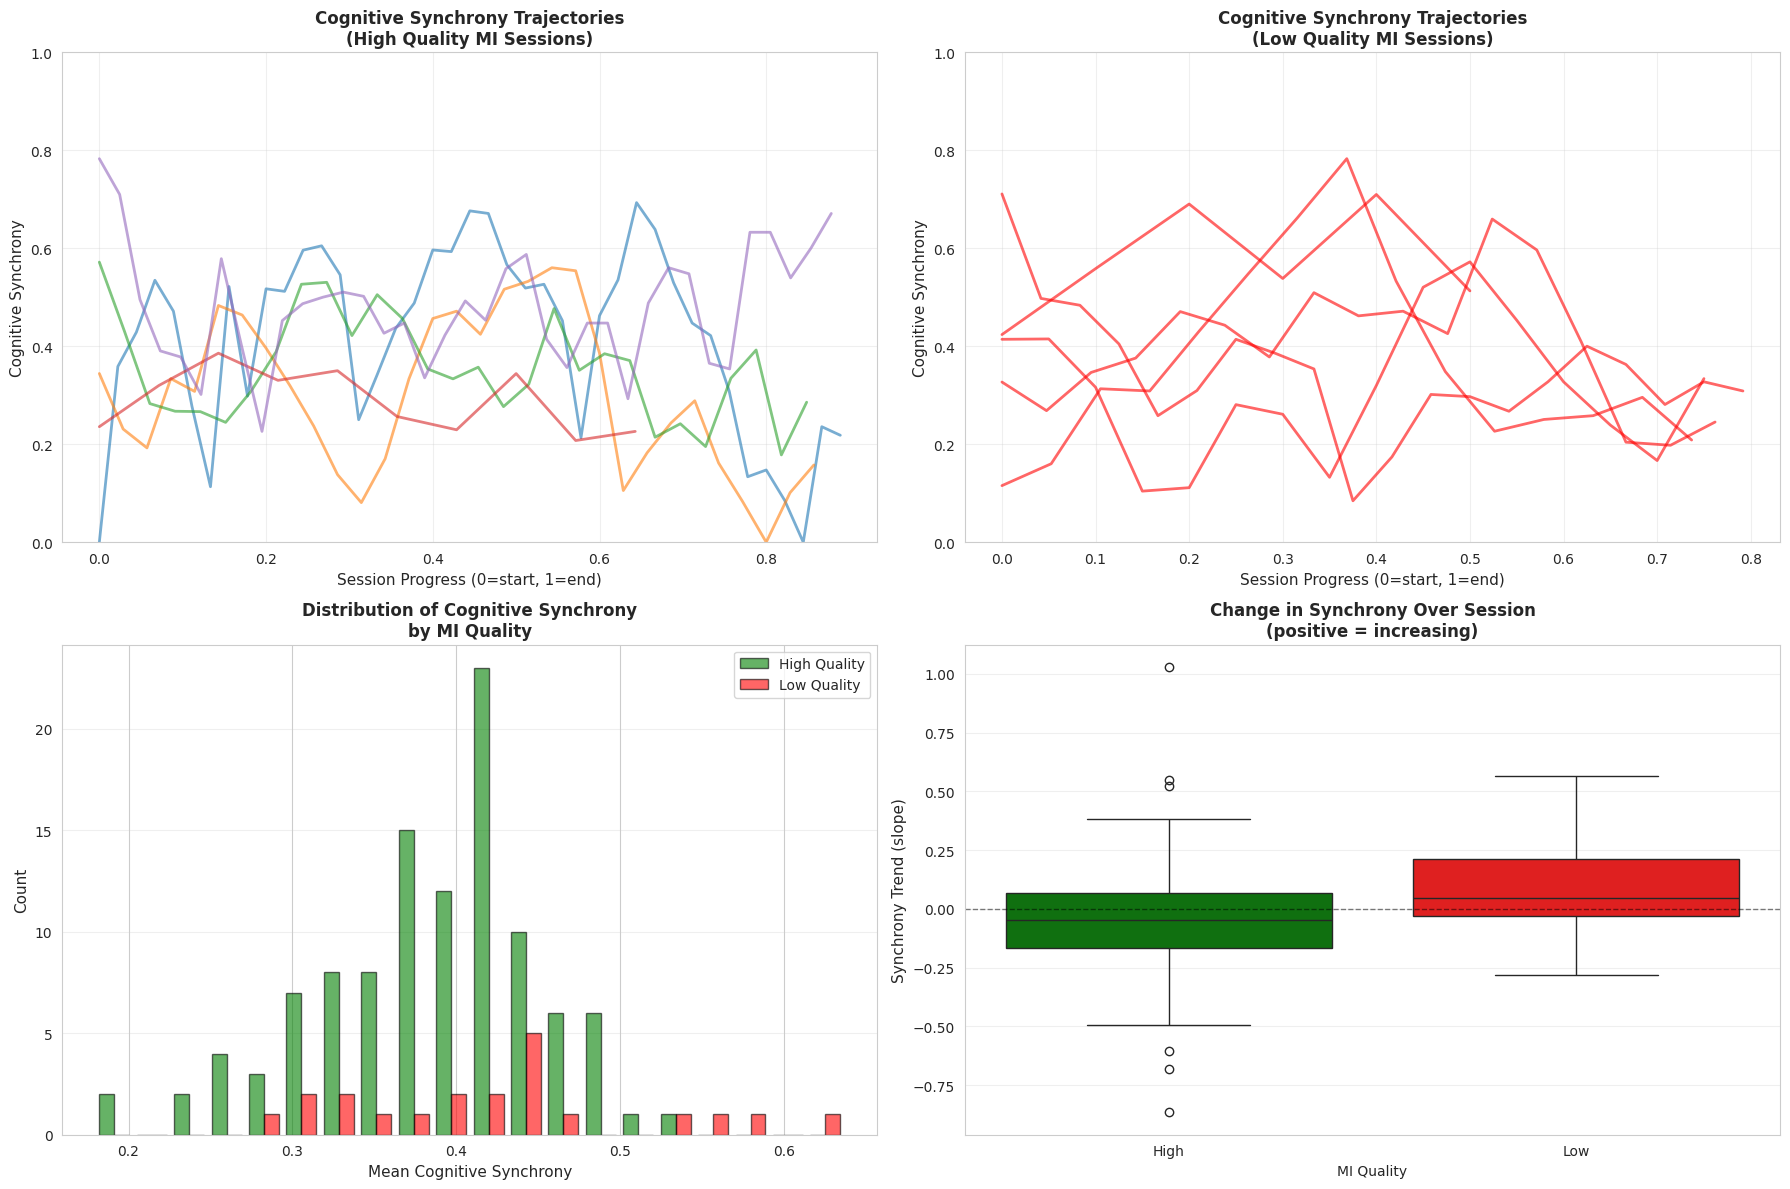

✅ Visualization saved: output/analysis_AnnoMI/advanced_1_synchrony.png


In [37]:
# Visualize synchrony over time
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Example trajectories (high quality)
high_quality_examples = [r for r in synchrony_results if r['mi_quality'] == 'high'][:5]
for result in high_quality_examples:
    axes[0, 0].plot(result['positions'], result['synchrony_scores'], alpha=0.6, linewidth=2)
axes[0, 0].set_xlabel('Session Progress (0=start, 1=end)', fontsize=11)
axes[0, 0].set_ylabel('Cognitive Synchrony', fontsize=11)
axes[0, 0].set_title('Cognitive Synchrony Trajectories\n(High Quality MI Sessions)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 1])

# Plot 2: Example trajectories (low quality)
low_quality_examples = [r for r in synchrony_results if r['mi_quality'] == 'low'][:5]
for result in low_quality_examples:
    axes[0, 1].plot(result['positions'], result['synchrony_scores'], alpha=0.6, linewidth=2, color='red')
axes[0, 1].set_xlabel('Session Progress (0=start, 1=end)', fontsize=11)
axes[0, 1].set_ylabel('Cognitive Synchrony', fontsize=11)
axes[0, 1].set_title('Cognitive Synchrony Trajectories\n(Low Quality MI Sessions)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# Plot 3: Distribution comparison
axes[1, 0].hist([high_quality_sync, low_quality_sync], bins=20, label=['High Quality', 'Low Quality'],
                color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1, 0].set_xlabel('Mean Cognitive Synchrony', fontsize=11)
axes[1, 0].set_ylabel('Count', fontsize=11)
axes[1, 0].set_title('Distribution of Cognitive Synchrony\nby MI Quality', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Synchrony trends
trend_data = pd.DataFrame([
    {'MI Quality': 'High', 'Trend': t} for t in high_quality_trend
] + [
    {'MI Quality': 'Low', 'Trend': t} for t in low_quality_trend
])
sns.boxplot(data=trend_data, x='MI Quality', y='Trend', ax=axes[1, 1], palette=['green', 'red'])
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].set_ylabel('Synchrony Trend (slope)', fontsize=11)
axes[1, 1].set_title('Change in Synchrony Over Session\n(positive = increasing)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/advanced_1_synchrony.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/advanced_1_synchrony.png")

## 2️⃣ Change Talk Prediction

Predict client change talk from cognitive action patterns.

In [38]:
print("="*80)
print("CHANGE TALK PREDICTION")
print("="*80)

# Filter client utterances with talk type labels
client_df = df[df['interlocutor'] == 'client'].copy()
client_df = client_df[client_df['client_talk_type'].notna()].copy()

print(f"\n📊 Client talk type distribution:")
talk_type_counts = client_df['client_talk_type'].value_counts()
for talk_type, count in talk_type_counts.items():
    print(f"   {talk_type:20s}: {count:4d} ({count/len(client_df)*100:.1f}%)")

# Define change talk categories
change_talk_types = ['change']
sustain_talk_types = ['sustain']
neutral_types = ['neutral', 'follow/neutral']

client_df['is_change_talk'] = client_df['client_talk_type'].isin(change_talk_types)
client_df['is_sustain_talk'] = client_df['client_talk_type'].isin(sustain_talk_types)

# Analyze cognitive patterns for change vs sustain talk
change_talk_actions = Counter()
sustain_talk_actions = Counter()
neutral_talk_actions = Counter()

for _, row in client_df.iterrows():
    for action_data in row['active_actions']:
        action = action_data['action']
        confidence = action_data['confidence']
        
        if row['is_change_talk']:
            change_talk_actions[action] += confidence
        elif row['is_sustain_talk']:
            sustain_talk_actions[action] += confidence
        elif row['client_talk_type'] in neutral_types:
            neutral_talk_actions[action] += confidence

print("\n" + "="*80)
print("CHANGE TALK - Top 15 Cognitive Actions")
print("="*80)
for action, score in change_talk_actions.most_common(15):
    print(f"{action:35s} {score:7.2f}")

print("\n" + "="*80)
print("SUSTAIN TALK - Top 15 Cognitive Actions")
print("="*80)
for action, score in sustain_talk_actions.most_common(15):
    print(f"{action:35s} {score:7.2f}")

# Find distinctive actions for change talk
print("\n" + "="*80)
print("DISTINCTIVE ACTIONS FOR CHANGE TALK")
print("="*80)

# Calculate ratio: change_talk / (sustain_talk + epsilon)
change_ratios = []
for action in all_actions:
    change_score = change_talk_actions.get(action, 0) + 1e-6
    sustain_score = sustain_talk_actions.get(action, 0) + 1e-6
    ratio = change_score / sustain_score
    if change_score > 5:  # Only actions with reasonable frequency
        change_ratios.append((action, ratio, change_score, sustain_score))

change_ratios.sort(key=lambda x: x[1], reverse=True)

print("\nActions MORE common in change talk:")
for action, ratio, change_score, sustain_score in change_ratios[:10]:
    print(f"{action:35s} ratio: {ratio:6.2f}x  (change: {change_score:6.2f}, sustain: {sustain_score:6.2f})")

print("\nActions MORE common in sustain talk:")
for action, ratio, change_score, sustain_score in sorted(change_ratios, key=lambda x: x[1])[:10]:
    print(f"{action:35s} ratio: {ratio:6.2f}x  (change: {change_score:6.2f}, sustain: {sustain_score:6.2f})")

CHANGE TALK PREDICTION

📊 Client talk type distribution:
   neutral             : 2065 (57.0%)
   change              : 1044 (28.8%)
   sustain             :  515 (14.2%)

CHANGE TALK - Top 15 Cognitive Actions
noticing                             420.43
self_questioning                     338.11
response_modulation                  336.25
reframing                            292.86
evaluating                           238.61
understanding                        232.67
analogical_thinking                  217.26
reconsidering                        182.00
convergent_thinking                  178.60
hypothesis_generation                165.73
emotion_responding                   136.56
counterfactual_reasoning             130.94
emotion_understanding                123.95
distinguishing                       120.89
questioning                          120.11

SUSTAIN TALK - Top 15 Cognitive Actions
noticing                             215.51
self_questioning                     157.05


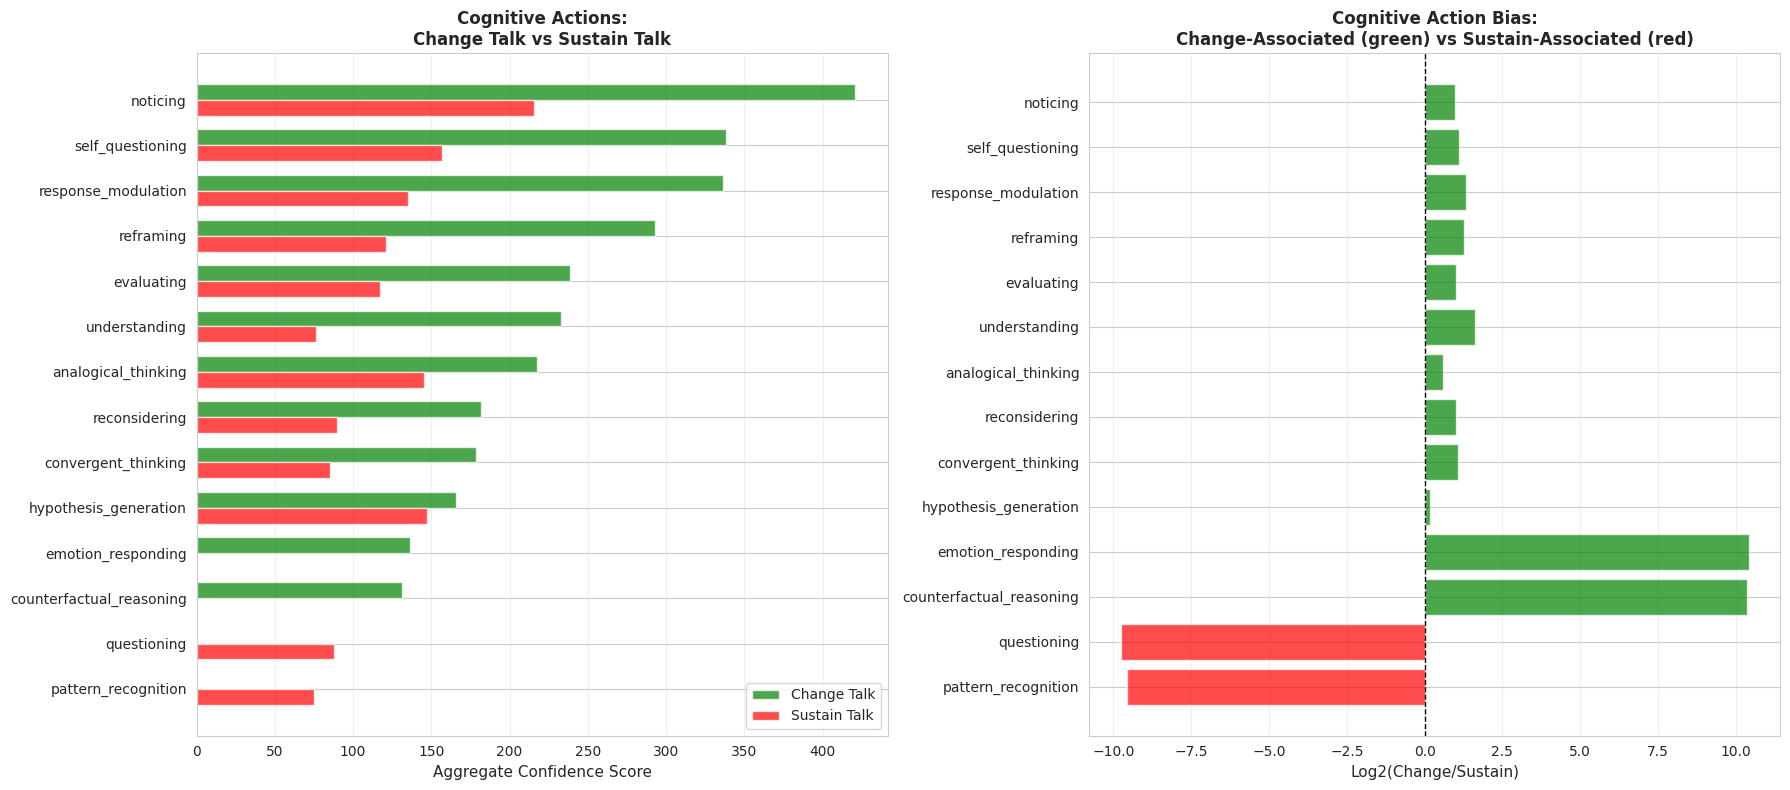

✅ Visualization saved: output/analysis_AnnoMI/advanced_2_change_talk.png


In [39]:
# Visualize change talk patterns
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Get top actions for each type
top_change = dict(change_talk_actions.most_common(12))
top_sustain = dict(sustain_talk_actions.most_common(12))

# Combine
all_talk_actions = sorted(
    set(list(top_change.keys()) + list(top_sustain.keys())),
    key=lambda x: max(top_change.get(x, 0), top_sustain.get(x, 0)),
    reverse=True
)

change_scores = [top_change.get(a, 0) for a in all_talk_actions]
sustain_scores = [top_sustain.get(a, 0) for a in all_talk_actions]

# Plot 1: Comparison
x = np.arange(len(all_talk_actions))
width = 0.35

axes[0].barh(x - width/2, change_scores, width, label='Change Talk', color='green', alpha=0.7)
axes[0].barh(x + width/2, sustain_scores, width, label='Sustain Talk', color='red', alpha=0.7)
axes[0].set_yticks(x)
axes[0].set_yticklabels(all_talk_actions, fontsize=10)
axes[0].set_xlabel('Aggregate Confidence Score', fontsize=11)
axes[0].set_title('Cognitive Actions:\nChange Talk vs Sustain Talk', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Plot 2: Ratio (log scale)
ratios = []
ratio_actions = []
for action in all_talk_actions:
    c_score = top_change.get(action, 0.1)
    s_score = top_sustain.get(action, 0.1)
    ratio = np.log2(c_score / s_score)
    ratios.append(ratio)
    ratio_actions.append(action)

colors = ['green' if r > 0 else 'red' for r in ratios]
axes[1].barh(range(len(ratio_actions)), ratios, color=colors, alpha=0.7)
axes[1].set_yticks(range(len(ratio_actions)))
axes[1].set_yticklabels(ratio_actions, fontsize=10)
axes[1].set_xlabel('Log2(Change/Sustain)', fontsize=11)
axes[1].set_title('Cognitive Action Bias:\nChange-Associated (green) vs Sustain-Associated (red)', 
                  fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/advanced_2_change_talk.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/advanced_2_change_talk.png")

## 3️⃣ Critical Moment Detection

Identify breakthrough moments and stuck points in therapy sessions.

In [40]:
print("="*80)
print("CRITICAL MOMENT DETECTION")
print("="*80)

# Define features for critical moment detection
def calculate_utterance_features(row):
    """Calculate features that might indicate critical moments"""
    actions = row['action_names']
    
    # Feature 1: Cognitive diversity
    cognitive_diversity = len(actions)
    
    # Feature 2: Metacognitive index
    metacog_actions = ['meta_awareness', 'metacognitive_monitoring', 'metacognitive_regulation', 
                       'self_questioning', 'cognition_awareness']
    metacog_score = sum(1 for a in actions if a in metacog_actions)
    
    # Feature 3: Emotional processing
    emotion_actions = ['emotion_perception', 'emotion_understanding', 'emotional_reappraisal',
                       'emotion_responding', 'emotion_management']
    emotion_score = sum(1 for a in actions if a in emotion_actions)
    
    # Feature 4: Perspective transformation
    transform_actions = ['perspective_taking', 'reframing', 'reconsidering', 'updating_beliefs']
    transform_score = sum(1 for a in actions if a in transform_actions)
    
    # Feature 5: Integration (combination of high-level processes)
    integration_score = metacog_score * (emotion_score + transform_score)
    
    # Feature 6: Complexity (unique cognitive actions)
    complexity = len(set(actions))
    
    return {
        'cognitive_diversity': cognitive_diversity,
        'metacognitive_index': metacog_score,
        'emotional_processing': emotion_score,
        'perspective_transformation': transform_score,
        'integration_score': integration_score,
        'complexity': complexity
    }

# Calculate features for all utterances
features_list = []
for _, row in df.iterrows():
    features = calculate_utterance_features(row)
    features_list.append(features)

features_df = pd.DataFrame(features_list)
df = pd.concat([df.reset_index(drop=True), features_df], axis=1)

# Define breakthrough moments (high integration + metacognition)
# Use top 5% as breakthrough moments
breakthrough_threshold = df['integration_score'].quantile(0.95)
df['is_breakthrough'] = (df['integration_score'] >= breakthrough_threshold) & \
                        (df['metacognitive_index'] >= 1)

print(f"\n🎯 Detected {df['is_breakthrough'].sum()} breakthrough moments ({df['is_breakthrough'].sum()/len(df)*100:.2f}%)")

# Analyze breakthrough moments
breakthrough_df = df[df['is_breakthrough']].copy()

print("\n" + "="*80)
print("BREAKTHROUGH MOMENT CHARACTERISTICS")
print("="*80)
print(f"   Mean cognitive diversity: {breakthrough_df['cognitive_diversity'].mean():.2f}")
print(f"   Mean metacognitive index: {breakthrough_df['metacognitive_index'].mean():.2f}")
print(f"   Mean emotional processing: {breakthrough_df['emotional_processing'].mean():.2f}")
print(f"   Mean perspective transformation: {breakthrough_df['perspective_transformation'].mean():.2f}")

# Show examples of breakthrough moments
print("\n" + "="*80)
print("EXAMPLE BREAKTHROUGH MOMENTS (Top 5 by integration score)")
print("="*80)

top_breakthroughs = df.nlargest(5, 'integration_score')
for i, (_, row) in enumerate(top_breakthroughs.iterrows(), 1):
    print(f"\n{i}. [{row['interlocutor'].upper()}] (integration={row['integration_score']:.1f})")
    print(f"   Text: {row['utterance_text'][:200]}...")
    print(f"   Actions: {', '.join(row['action_names'][:10])}")
    print(f"   Features: metacog={row['metacognitive_index']}, emotion={row['emotional_processing']}, transform={row['perspective_transformation']}")

# Detect stuck points (low complexity, repetitive)
# Group by transcript and detect repeated low-complexity sequences
stuck_points = []

for transcript_id in df['transcript_id'].unique():
    transcript_df = df[df['transcript_id'] == transcript_id].sort_values('utterance_id')
    
    # Sliding window to detect stuck points
    window_size = 5
    for i in range(len(transcript_df) - window_size + 1):
        window = transcript_df.iloc[i:i+window_size]
        
        # Low average complexity and diversity
        avg_complexity = window['complexity'].mean()
        avg_diversity = window['cognitive_diversity'].mean()
        
        if avg_complexity < 2 and avg_diversity < 2:
            stuck_points.append({
                'transcript_id': transcript_id,
                'start_position': i / len(transcript_df),
                'avg_complexity': avg_complexity,
                'avg_diversity': avg_diversity,
                'utterances': window['utterance_text'].tolist()
            })

print(f"\n\n🔴 Detected {len(stuck_points)} potential stuck points")

if len(stuck_points) > 0:
    print("\n" + "="*80)
    print("EXAMPLE STUCK POINTS (Low complexity windows)")
    print("="*80)
    
    for i, stuck in enumerate(stuck_points[:3], 1):
        print(f"\n{i}. Transcript {stuck['transcript_id']}, position {stuck['start_position']:.2%}")
        print(f"   Avg complexity: {stuck['avg_complexity']:.2f}, diversity: {stuck['avg_diversity']:.2f}")
        print(f"   Sample utterances:")
        for utt in stuck['utterances'][:3]:
            print(f"      - {utt[:100]}...")

CRITICAL MOMENT DETECTION

🎯 Detected 1012 breakthrough moments (13.73%)

BREAKTHROUGH MOMENT CHARACTERISTICS
   Mean cognitive diversity: 6.26
   Mean metacognitive index: 1.27
   Mean emotional processing: 1.12
   Mean perspective transformation: 0.96

EXAMPLE BREAKTHROUGH MOMENTS (Top 5 by integration score)

1. [THERAPIST] (integration=15.0)
   Text: Hi, Nick. Thank you for completing the CRAFFT questionnaire. I also appreciate you sharing some information about yourself....
   Actions: emotion_understanding, convergent_thinking, emotion_management, emotional_reappraisal, cognition_awareness, emotion_responding, evaluating, metacognitive_regulation, response_modulation, self_questioning
   Features: metacog=3, emotion=4, transform=1

2. [THERAPIST] (integration=10.0)
   Text: Hello, Kaylie, I'm Lori, the pharmacist here at Bulldog Pharmacy. I see that you have a new prescription for cholesterol statin 20 called in by Dr. Ferris today. I wondered if you had a minute to talk...
   Ac

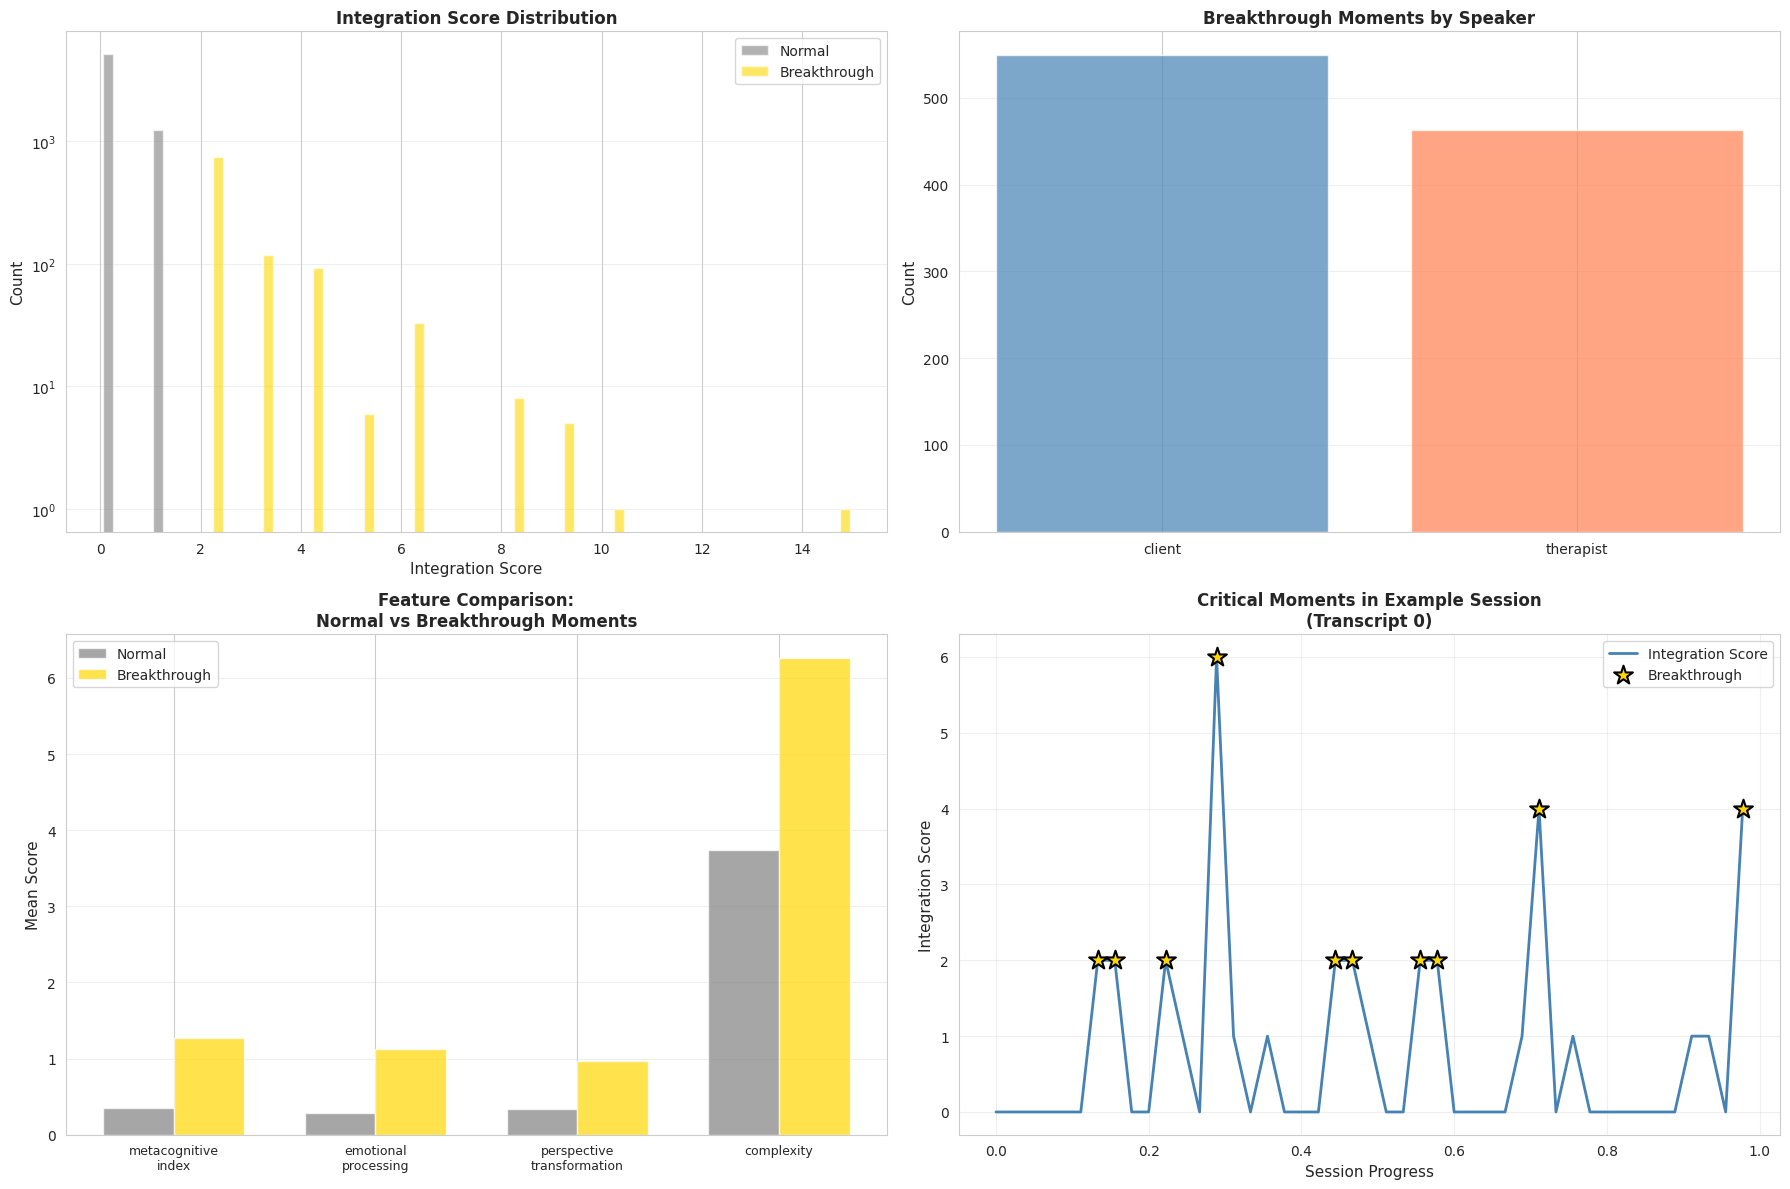

✅ Visualization saved: output/analysis_AnnoMI/advanced_3_critical_moments.png


In [41]:
# Visualize critical moments
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Feature distributions for breakthrough vs normal
normal_df = df[~df['is_breakthrough']]

axes[0, 0].hist([normal_df['integration_score'], breakthrough_df['integration_score']], 
                bins=30, label=['Normal', 'Breakthrough'], color=['gray', 'gold'], alpha=0.6)
axes[0, 0].set_xlabel('Integration Score', fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].set_title('Integration Score Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Breakthrough moments by interlocutor
breakthrough_by_interlocutor = breakthrough_df['interlocutor'].value_counts()
axes[0, 1].bar(breakthrough_by_interlocutor.index, breakthrough_by_interlocutor.values, 
               color=['steelblue', 'coral'], alpha=0.7)
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].set_title('Breakthrough Moments by Speaker', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Feature comparison (breakthrough vs normal)
feature_names = ['metacognitive_index', 'emotional_processing', 'perspective_transformation', 'complexity']
normal_means = [normal_df[f].mean() for f in feature_names]
breakthrough_means = [breakthrough_df[f].mean() for f in feature_names]

x = np.arange(len(feature_names))
width = 0.35

axes[1, 0].bar(x - width/2, normal_means, width, label='Normal', color='gray', alpha=0.7)
axes[1, 0].bar(x + width/2, breakthrough_means, width, label='Breakthrough', color='gold', alpha=0.7)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([f.replace('_', '\n') for f in feature_names], fontsize=9)
axes[1, 0].set_ylabel('Mean Score', fontsize=11)
axes[1, 0].set_title('Feature Comparison:\nNormal vs Breakthrough Moments', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Breakthrough moments across session (example transcript)
# Pick a high-quality transcript with breakthrough moments
example_transcript = None
for tid in df['transcript_id'].unique():
    t_df = df[df['transcript_id'] == tid]
    if t_df['is_breakthrough'].sum() >= 2 and t_df['mi_quality'].iloc[0] == 'high':
        example_transcript = tid
        break

if example_transcript is not None:
    t_df = df[df['transcript_id'] == example_transcript].sort_values('utterance_id')
    positions = np.arange(len(t_df)) / len(t_df)
    
    axes[1, 1].plot(positions, t_df['integration_score'].values, color='steelblue', linewidth=2, label='Integration Score')
    
    # Mark breakthrough moments
    breakthrough_positions = positions[t_df['is_breakthrough'].values]
    breakthrough_scores = t_df[t_df['is_breakthrough']]['integration_score'].values
    axes[1, 1].scatter(breakthrough_positions, breakthrough_scores, color='gold', s=200, 
                       marker='*', edgecolors='black', linewidths=1.5, label='Breakthrough', zorder=5)
    
    axes[1, 1].set_xlabel('Session Progress', fontsize=11)
    axes[1, 1].set_ylabel('Integration Score', fontsize=11)
    axes[1, 1].set_title(f'Critical Moments in Example Session\n(Transcript {example_transcript})', 
                         fontsize=12, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No suitable example transcript found', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_xticks([])
    axes[1, 1].set_yticks([])

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/advanced_3_critical_moments.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/advanced_3_critical_moments.png")

## 4️⃣ Therapist Style Profiling

Cluster therapists by their cognitive action patterns to identify therapeutic styles.

In [42]:
print("="*80)
print("THERAPIST STYLE PROFILING")
print("="*80)

# Create therapist profiles based on cognitive action patterns
# Since we don't have explicit therapist IDs, we'll use transcripts as proxies

therapist_profiles = []

for transcript_id in df['transcript_id'].unique():
    therapist_df = df[(df['transcript_id'] == transcript_id) & 
                      (df['interlocutor'] == 'therapist')]
    
    if len(therapist_df) < 5:  # Skip transcripts with too few therapist utterances
        continue
    
    # Create cognitive action profile (frequency vector)
    action_counts = Counter()
    for actions in therapist_df['action_names']:
        for action in actions:
            action_counts[action] += 1
    
    # Normalize by number of utterances
    action_profile = {action: count / len(therapist_df) 
                     for action, count in action_counts.items()}
    
    # Create feature vector
    profile_vector = [action_profile.get(action, 0) for action in all_actions]
    
    therapist_profiles.append({
        'transcript_id': transcript_id,
        'profile_vector': profile_vector,
        'action_counts': action_counts,
        'num_utterances': len(therapist_df),
        'mi_quality': therapist_df['mi_quality'].iloc[0],
        'topic': therapist_df['topic'].iloc[0]
    })

print(f"\n✅ Created {len(therapist_profiles)} therapist profiles")

# Create feature matrix
X = np.array([p['profile_vector'] for p in therapist_profiles])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"\n📊 PCA explained variance: {pca.explained_variance_ratio_[0]:.2%}, {pca.explained_variance_ratio_[1]:.2%}")

# Cluster therapists
# Try different numbers of clusters
silhouette_scores = []
for n_clusters in range(2, 8):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append((n_clusters, score))

print("\n📈 Silhouette scores for different cluster counts:")
for n, score in silhouette_scores:
    print(f"   {n} clusters: {score:.3f}")

# Use optimal number of clusters
optimal_k = max(silhouette_scores, key=lambda x: x[1])[0]
print(f"\n✅ Optimal number of clusters: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to profiles
for i, profile in enumerate(therapist_profiles):
    profile['cluster'] = cluster_labels[i]
    profile['pca_x'] = X_pca[i, 0]
    profile['pca_y'] = X_pca[i, 1]

# Analyze each cluster
print("\n" + "="*80)
print("THERAPIST STYLE CLUSTERS")
print("="*80)

for cluster_id in range(optimal_k):
    cluster_profiles = [p for p in therapist_profiles if p['cluster'] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id + 1} - {len(cluster_profiles)} therapists ({len(cluster_profiles)/len(therapist_profiles)*100:.1f}%)")
    print(f"{'='*80}")
    
    # Aggregate actions for this cluster
    cluster_actions = Counter()
    for profile in cluster_profiles:
        cluster_actions.update(profile['action_counts'])
    
    # Normalize by number of profiles
    total_utterances = sum(p['num_utterances'] for p in cluster_profiles)
    
    print(f"\nTop 10 characteristic cognitive actions:")
    for action, count in cluster_actions.most_common(10):
        avg_per_utterance = count / total_utterances
        print(f"   {action:35s} {avg_per_utterance:.3f} per utterance")
    
    # MI quality distribution
    high_quality = sum(1 for p in cluster_profiles if p['mi_quality'] == 'high')
    print(f"\nMI Quality: {high_quality}/{len(cluster_profiles)} high quality ({high_quality/len(cluster_profiles)*100:.1f}%)")
    
    # Topic distribution
    topics = Counter(p['topic'] for p in cluster_profiles)
    print(f"\nTop topics:")
    for topic, count in topics.most_common(3):
        print(f"   {topic}: {count}")

THERAPIST STYLE PROFILING

✅ Created 128 therapist profiles

📊 PCA explained variance: 8.66%, 7.17%

📈 Silhouette scores for different cluster counts:
   2 clusters: 0.089
   3 clusters: 0.071
   4 clusters: 0.096
   5 clusters: 0.087
   6 clusters: 0.087
   7 clusters: -0.004

✅ Optimal number of clusters: 4

THERAPIST STYLE CLUSTERS

CLUSTER 1 - 95 therapists (74.2%)

Top 10 characteristic cognitive actions:
   noticing                            0.533 per utterance
   self_questioning                    0.320 per utterance
   response_modulation                 0.303 per utterance
   reframing                           0.226 per utterance
   questioning                         0.216 per utterance
   emotion_understanding               0.213 per utterance
   analogical_thinking                 0.177 per utterance
   divergent_thinking                  0.159 per utterance
   abstracting                         0.157 per utterance
   convergent_thinking                 0.145 per uttera

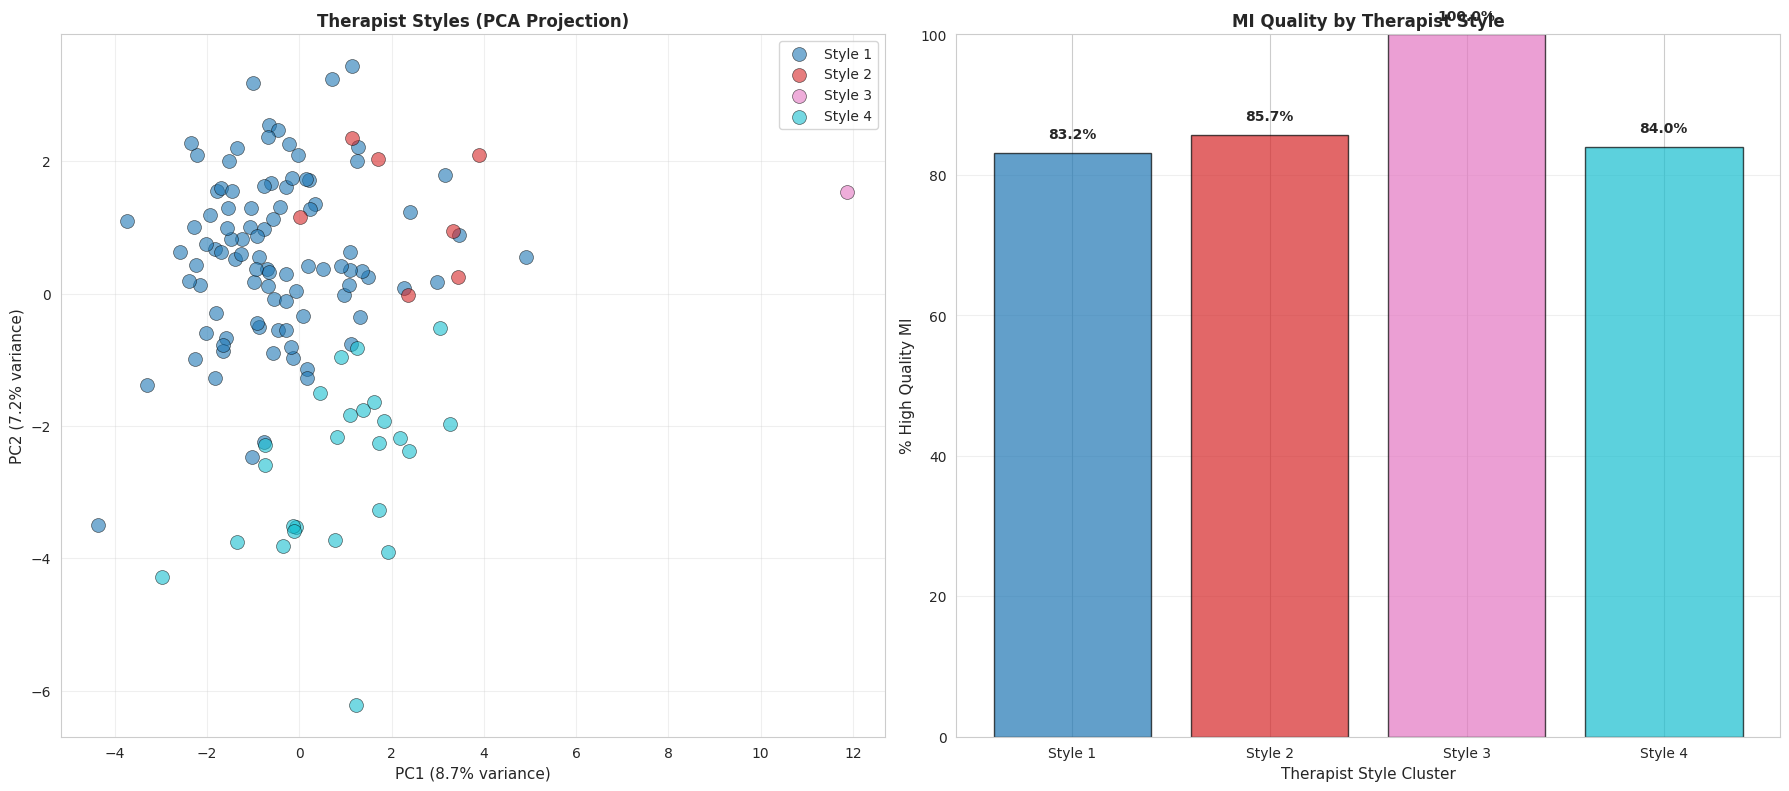

✅ Visualization saved: output/analysis_AnnoMI/advanced_4_therapist_styles.png


In [43]:
# Visualize therapist styles
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: PCA scatter colored by cluster
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))
for cluster_id in range(optimal_k):
    cluster_profiles = [p for p in therapist_profiles if p['cluster'] == cluster_id]
    x_coords = [p['pca_x'] for p in cluster_profiles]
    y_coords = [p['pca_y'] for p in cluster_profiles]
    axes[0].scatter(x_coords, y_coords, c=[colors[cluster_id]], 
                   s=100, alpha=0.6, edgecolors='black', linewidths=0.5,
                   label=f'Style {cluster_id + 1}')

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[0].set_title('Therapist Styles (PCA Projection)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: MI quality by cluster
cluster_quality = []
for cluster_id in range(optimal_k):
    cluster_profiles = [p for p in therapist_profiles if p['cluster'] == cluster_id]
    high_quality_pct = sum(1 for p in cluster_profiles if p['mi_quality'] == 'high') / len(cluster_profiles) * 100
    cluster_quality.append(high_quality_pct)

axes[1].bar(range(1, optimal_k + 1), cluster_quality, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Therapist Style Cluster', fontsize=11)
axes[1].set_ylabel('% High Quality MI', fontsize=11)
axes[1].set_title('MI Quality by Therapist Style', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(1, optimal_k + 1))
axes[1].set_xticklabels([f'Style {i}' for i in range(1, optimal_k + 1)])
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 100])

# Add percentage labels on bars
for i, pct in enumerate(cluster_quality):
    axes[1].text(i + 1, pct + 2, f'{pct:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/advanced_4_therapist_styles.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/advanced_4_therapist_styles.png")

## 5️⃣ Sequential Pattern Modeling (Markov Chains)

Model conversation flow as Markov chains to understand transition probabilities.

In [44]:
print("="*80)
print("SEQUENTIAL PATTERN MODELING - MARKOV CHAINS")
print("="*80)

# Build transition matrix for cognitive actions
# Focus on top N most common actions for clarity
TOP_N_ACTIONS = 20

# Get top actions
all_action_counts = Counter()
for actions in df['action_names']:
    for action in actions:
        all_action_counts[action] += 1

top_actions = [action for action, _ in all_action_counts.most_common(TOP_N_ACTIONS)]
action_to_idx = {action: i for i, action in enumerate(top_actions)}

print(f"\n📊 Building transition matrix for top {TOP_N_ACTIONS} actions...")

# Initialize transition matrix
transition_matrix = np.zeros((TOP_N_ACTIONS, TOP_N_ACTIONS))

# Count transitions
for transcript_id in df['transcript_id'].unique():
    transcript_df = df[df['transcript_id'] == transcript_id].sort_values('utterance_id')
    
    for i in range(len(transcript_df) - 1):
        current_actions = [a for a in transcript_df.iloc[i]['action_names'] if a in top_actions]
        next_actions = [a for a in transcript_df.iloc[i+1]['action_names'] if a in top_actions]
        
        for curr_action in current_actions:
            for next_action in next_actions:
                curr_idx = action_to_idx[curr_action]
                next_idx = action_to_idx[next_action]
                transition_matrix[curr_idx, next_idx] += 1

# Normalize rows to get probabilities
row_sums = transition_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # Avoid division by zero
transition_probs = transition_matrix / row_sums

print("\n✅ Transition matrix built")

# Find most common transitions
transitions = []
for i in range(TOP_N_ACTIONS):
    for j in range(TOP_N_ACTIONS):
        if transition_matrix[i, j] > 0:
            transitions.append((
                top_actions[i],
                top_actions[j],
                transition_matrix[i, j],
                transition_probs[i, j]
            ))

transitions.sort(key=lambda x: x[2], reverse=True)

print("\n" + "="*80)
print("TOP 20 COGNITIVE ACTION TRANSITIONS")
print("="*80)
print(f"{'From':25s} -> {'To':25s} {'Count':>6s} {'Prob':>8s}")
print("-" * 80)
for from_action, to_action, count, prob in transitions[:20]:
    print(f"{from_action:25s} -> {to_action:25s} {int(count):6d} {prob:7.1%}")

# Calculate stationary distribution (eigenvector with eigenvalue 1)
eigenvalues, eigenvectors = np.linalg.eig(transition_probs.T)
stationary_idx = np.argmin(np.abs(eigenvalues - 1))
stationary_dist = np.real(eigenvectors[:, stationary_idx])
stationary_dist = stationary_dist / stationary_dist.sum()

print("\n" + "="*80)
print("STATIONARY DISTRIBUTION (Long-term probabilities)")
print("="*80)

stationary_actions = sorted(zip(top_actions, stationary_dist), key=lambda x: x[1], reverse=True)
for action, prob in stationary_actions[:15]:
    bar = "█" * int(prob * 200)
    print(f"{action:35s} {prob:6.2%} {bar}")

SEQUENTIAL PATTERN MODELING - MARKOV CHAINS

📊 Building transition matrix for top 20 actions...

✅ Transition matrix built

TOP 20 COGNITIVE ACTION TRANSITIONS
From                      -> To                         Count     Prob
--------------------------------------------------------------------------------
noticing                  -> noticing                    1915   15.3%
self_questioning          -> noticing                    1313   14.7%
noticing                  -> self_questioning            1281   10.3%
response_modulation       -> noticing                    1077   14.1%
noticing                  -> response_modulation         1026    8.2%
reframing                 -> noticing                     990   14.5%
self_questioning          -> self_questioning             972   10.9%
noticing                  -> reframing                    970    7.8%
response_modulation       -> self_questioning             823   10.8%
self_questioning          -> response_modulation          

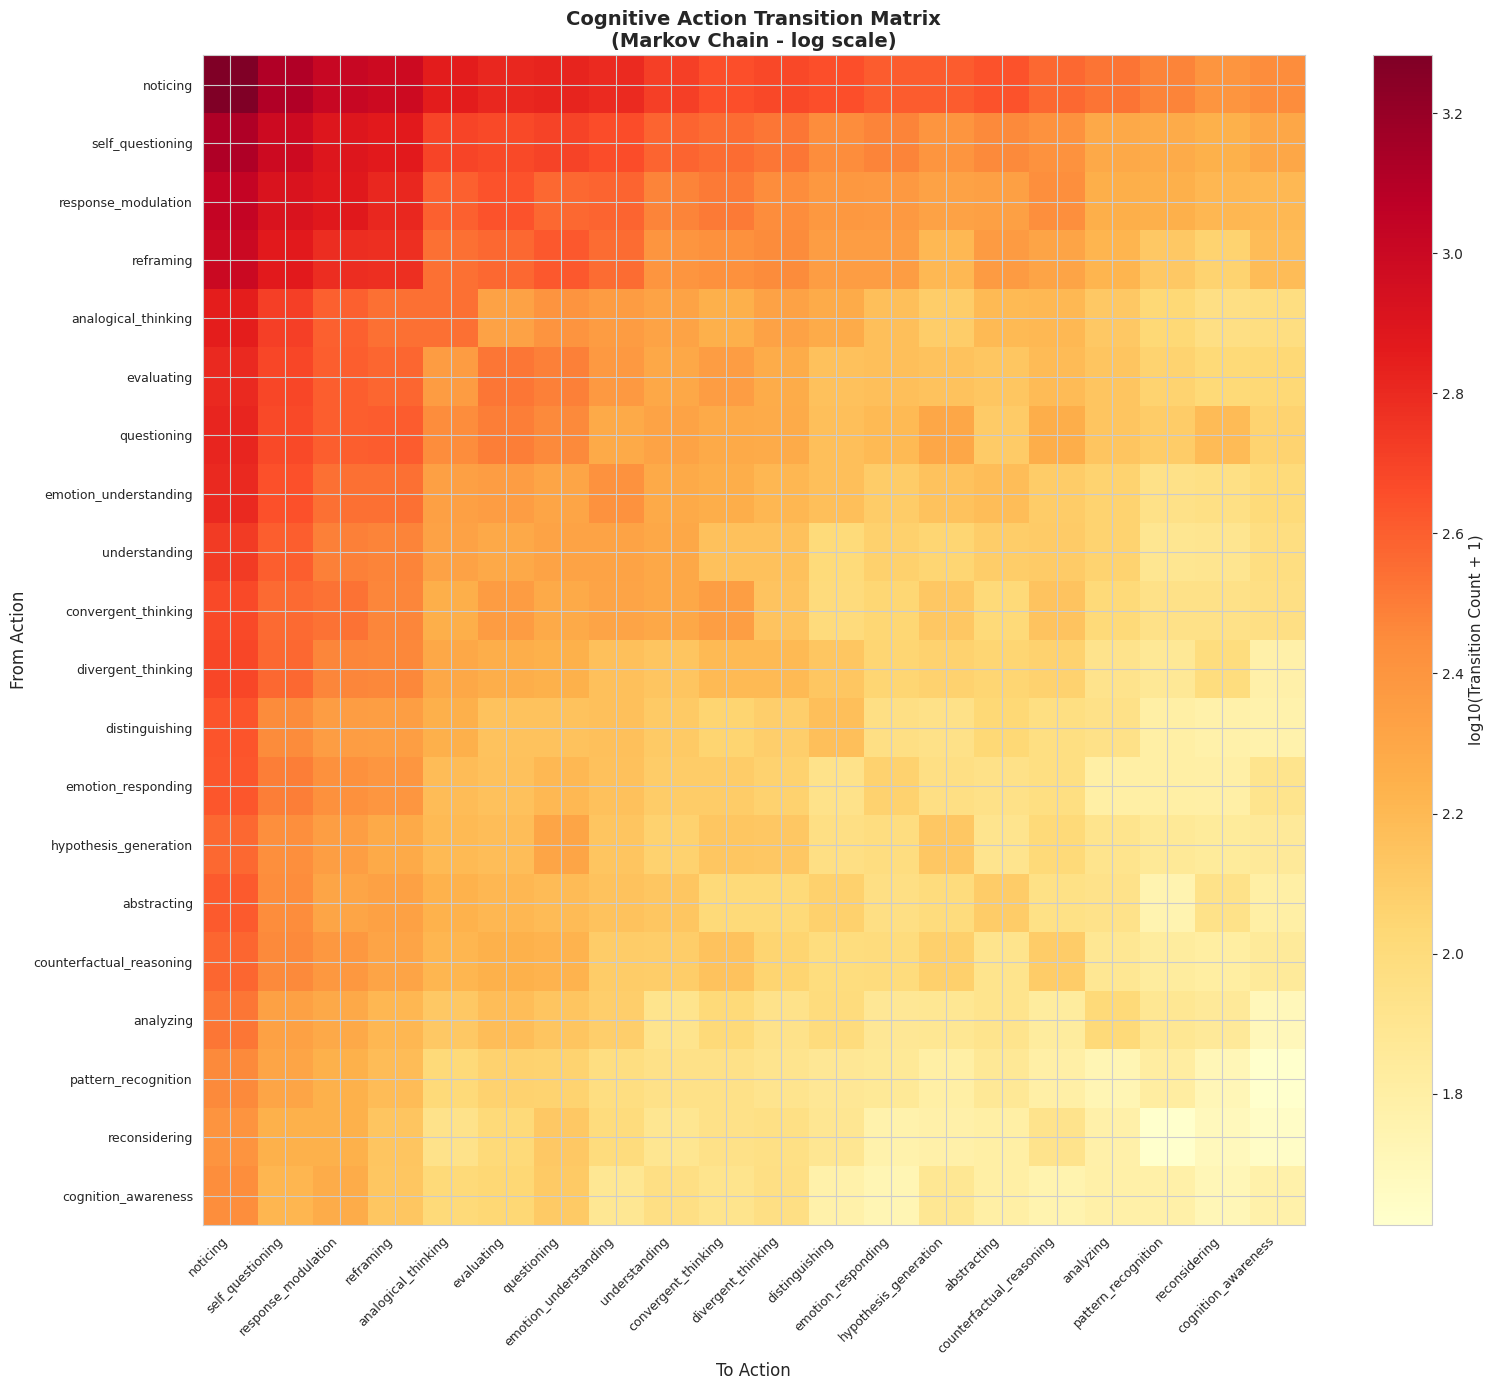

✅ Visualization saved: output/analysis_AnnoMI/advanced_5_markov_chain.png


In [45]:
# Visualize transition matrix
fig, ax = plt.subplots(figsize=(16, 14))

# Use log scale for better visibility
transition_matrix_log = np.log10(transition_matrix + 1)

im = ax.imshow(transition_matrix_log, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(TOP_N_ACTIONS))
ax.set_yticks(range(TOP_N_ACTIONS))
ax.set_xticklabels(top_actions, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(top_actions, fontsize=9)

ax.set_xlabel('To Action', fontsize=12)
ax.set_ylabel('From Action', fontsize=12)
ax.set_title('Cognitive Action Transition Matrix\n(Markov Chain - log scale)', 
             fontsize=14, fontweight='bold')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('log10(Transition Count + 1)', fontsize=11)

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/advanced_5_markov_chain.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/advanced_5_markov_chain.png")

## 6️⃣ Network Analysis

Graph-based analysis of cognitive action relationships.

In [46]:
print("="*80)
print("NETWORK ANALYSIS")
print("="*80)

# Create directed graph from transition matrix
G = nx.DiGraph()

# Add nodes
for action in top_actions:
    G.add_node(action)

# Add edges (only significant transitions, top 30%)
threshold = np.percentile([t[2] for t in transitions], 70)

for from_action, to_action, count, prob in transitions:
    if count >= threshold:
        G.add_edge(from_action, to_action, weight=count, prob=prob)

print(f"\n📊 Network statistics:")
print(f"   Nodes: {G.number_of_nodes()}")
print(f"   Edges: {G.number_of_edges()}")
print(f"   Density: {nx.density(G):.3f}")

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
pagerank = nx.pagerank(G)

print("\n" + "="*80)
print("TOP 10 ACTIONS BY CENTRALITY MEASURES")
print("="*80)

print("\nDegree Centrality (most connected):")
for action, score in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"   {action:35s} {score:.3f}")

print("\nBetweenness Centrality (bridges between other actions):")
for action, score in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"   {action:35s} {score:.3f}")

print("\nPageRank (importance in network):")
for action, score in sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"   {action:35s} {score:.3f}")

# Detect communities
# Convert to undirected for community detection
G_undirected = G.to_undirected()
communities = list(nx.community.greedy_modularity_communities(G_undirected))

print(f"\n📊 Detected {len(communities)} communities")

for i, community in enumerate(communities, 1):
    print(f"\nCommunity {i} ({len(community)} actions):")
    for action in sorted(community):
        print(f"   • {action}")

NETWORK ANALYSIS

📊 Network statistics:
   Nodes: 20
   Edges: 122
   Density: 0.321

TOP 10 ACTIONS BY CENTRALITY MEASURES

Degree Centrality (most connected):
   noticing                            2.105
   self_questioning                    1.684
   response_modulation                 1.474
   reframing                           1.316
   evaluating                          0.842
   analogical_thinking                 0.737
   questioning                         0.737
   emotion_understanding               0.684
   convergent_thinking                 0.474
   understanding                       0.421

Betweenness Centrality (bridges between other actions):
   noticing                            0.523
   self_questioning                    0.137
   response_modulation                 0.070
   reframing                           0.043
   evaluating                          0.003
   analogical_thinking                 0.000
   questioning                         0.000
   emotion_unders

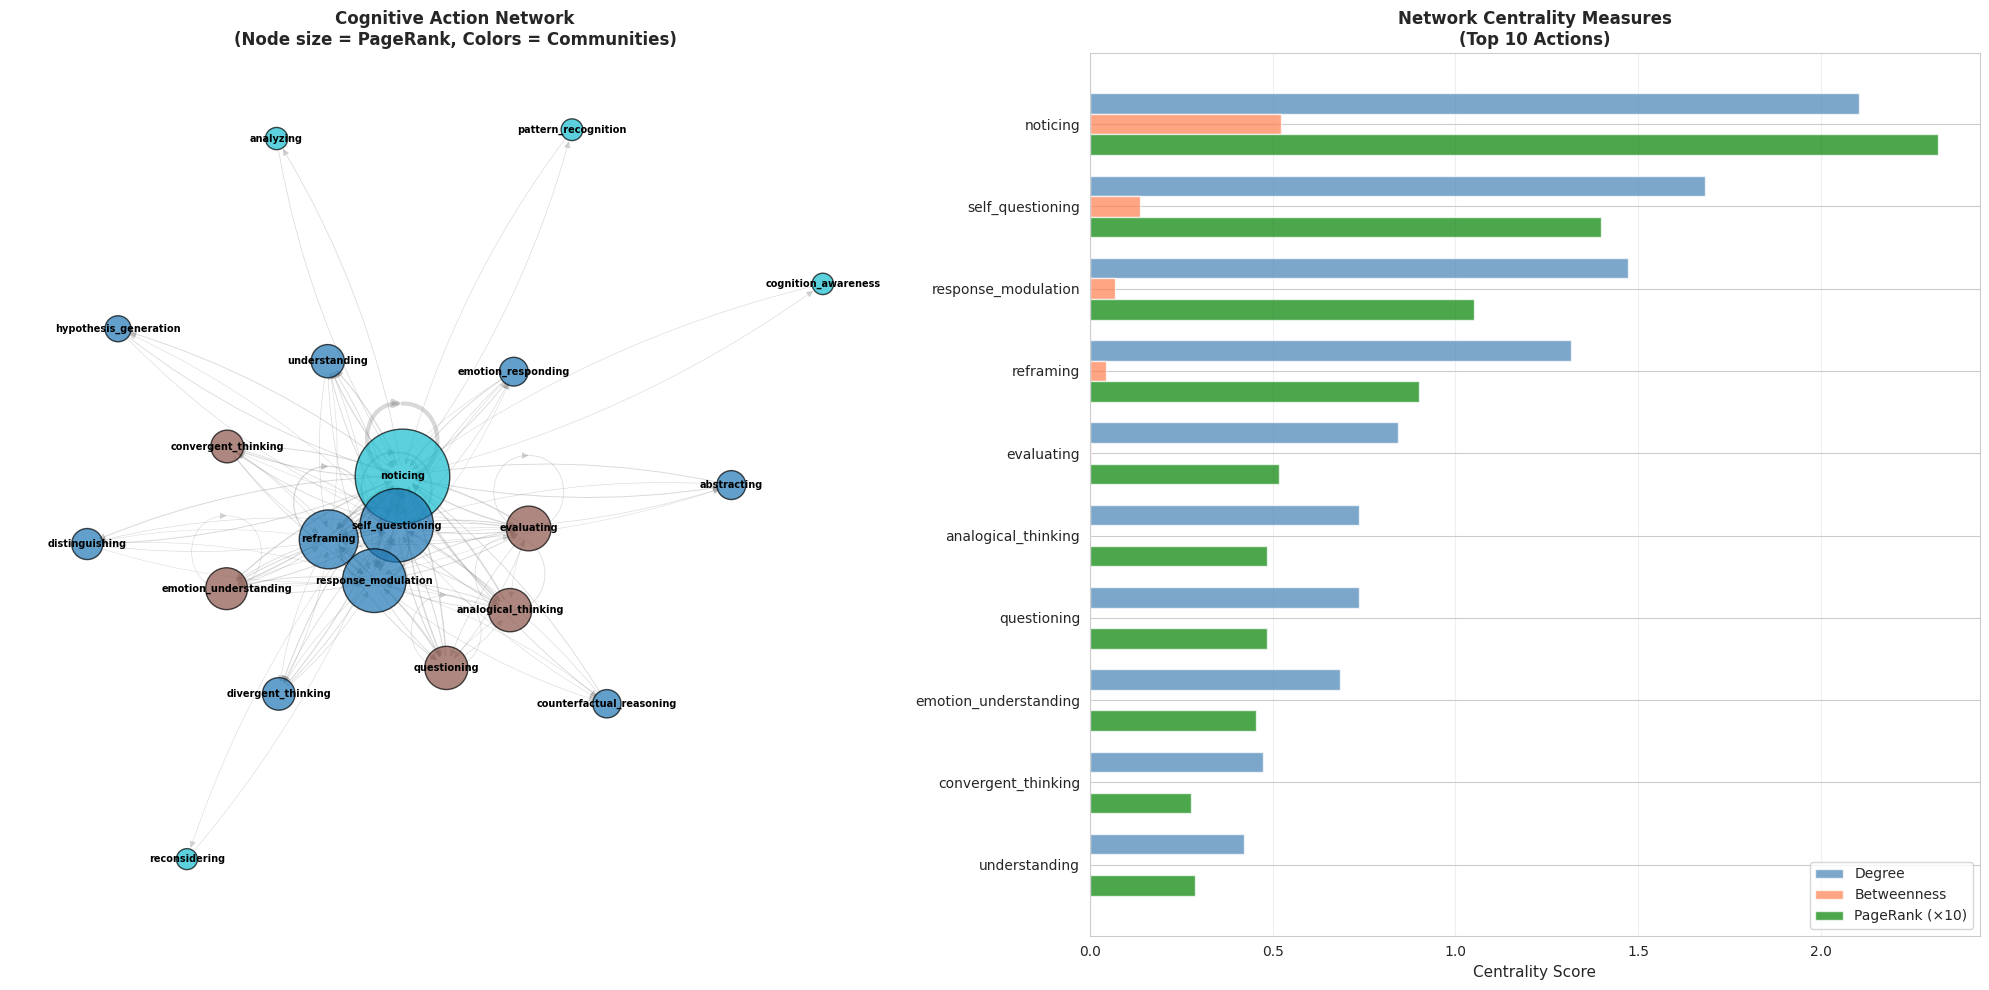

✅ Visualization saved: output/analysis_AnnoMI/advanced_6_network_analysis.png


In [47]:
# Visualize network
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Network graph with communities
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Color nodes by community
node_colors = []
community_colors = plt.cm.tab10(np.linspace(0, 1, len(communities)))
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

for node in G.nodes():
    comm_id = node_to_community.get(node, 0)
    node_colors.append(community_colors[comm_id])

# Node sizes by PageRank
node_sizes = [pagerank[node] * 20000 for node in G.nodes()]

# Draw network
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, 
                       alpha=0.7, edgecolors='black', linewidths=1, ax=axes[0])
nx.draw_networkx_labels(G, pos, font_size=7, font_weight='bold', ax=axes[0])

# Draw edges with varying thickness
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
max_weight = max(weights)
edge_widths = [w / max_weight * 3 for w in weights]

nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.3, 
                       arrows=True, arrowsize=10, ax=axes[0], 
                       edge_color='gray', connectionstyle='arc3,rad=0.1')

axes[0].set_title('Cognitive Action Network\n(Node size = PageRank, Colors = Communities)', 
                  fontsize=12, fontweight='bold')
axes[0].axis('off')

# Plot 2: Centrality comparison
top_10_actions_cent = list(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10])
actions_for_plot = [a for a, _ in top_10_actions_cent]

degree_scores = [degree_centrality[a] for a in actions_for_plot]
betweenness_scores = [betweenness_centrality[a] for a in actions_for_plot]
pagerank_scores = [pagerank[a] * 10 for a in actions_for_plot]  # Scale for visibility

x = np.arange(len(actions_for_plot))
width = 0.25

axes[1].barh(x - width, degree_scores, width, label='Degree', color='steelblue', alpha=0.7)
axes[1].barh(x, betweenness_scores, width, label='Betweenness', color='coral', alpha=0.7)
axes[1].barh(x + width, pagerank_scores, width, label='PageRank (×10)', color='green', alpha=0.7)

axes[1].set_yticks(x)
axes[1].set_yticklabels(actions_for_plot, fontsize=10)
axes[1].set_xlabel('Centrality Score', fontsize=11)
axes[1].set_title('Network Centrality Measures\n(Top 10 Actions)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/advanced_6_network_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/advanced_6_network_analysis.png")

## Summary and Export

In [48]:
print("="*80)
print("ADVANCED ANALYSIS SUMMARY")
print("="*80)

summary = {
    'synchrony_analysis': {
        'mean_high_quality': float(np.mean(high_quality_sync)) if len(high_quality_sync) > 0 else None,
        'mean_low_quality': float(np.mean(low_quality_sync)) if len(low_quality_sync) > 0 else None,
        'significance': 'p < 0.05' if p_val < 0.05 else 'not significant'
    },
    'change_talk': {
        'top_change_actions': [action for action, _ in change_talk_actions.most_common(10)],
        'top_sustain_actions': [action for action, _ in sustain_talk_actions.most_common(10)],
        'most_predictive_of_change': [action for action, _, _, _ in change_ratios[:5]]
    },
    'critical_moments': {
        'breakthrough_count': int(df['is_breakthrough'].sum()),
        'breakthrough_percentage': float(df['is_breakthrough'].sum() / len(df) * 100),
        'stuck_points_detected': len(stuck_points)
    },
    'therapist_styles': {
        'num_clusters': int(optimal_k),
        'cluster_sizes': [int(sum(1 for p in therapist_profiles if p['cluster'] == i)) 
                         for i in range(optimal_k)],
        'cluster_quality_percentages': [float(pct) for pct in cluster_quality]
    },
    'markov_chain': {
        'top_transitions': [(from_a, to_a, float(prob)) 
                           for from_a, to_a, _, prob in transitions[:10]],
        'stationary_distribution': {action: float(prob) 
                                   for action, prob in stationary_actions[:10]}
    },
    'network_analysis': {
        'num_nodes': int(G.number_of_nodes()),
        'num_edges': int(G.number_of_edges()),
        'density': float(nx.density(G)),
        'num_communities': len(communities),
        'top_pagerank': {action: float(score) 
                        for action, score in sorted(pagerank.items(), 
                                                   key=lambda x: x[1], reverse=True)[:10]}
    }
}

# Save summary
with open('output/analysis_AnnoMI/advanced_analysis_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n✅ Summary exported to: output/analysis_AnnoMI/advanced_analysis_summary.json")

print("\n" + "="*80)
print("ALL ANALYSES COMPLETE!")
print("="*80)
print("\nGenerated visualizations:")
print("   1. advanced_1_synchrony.png")
print("   2. advanced_2_change_talk.png")
print("   3. advanced_3_critical_moments.png")
print("   4. advanced_4_therapist_styles.png")
print("   5. advanced_5_markov_chain.png")
print("   6. advanced_6_network_analysis.png")
print("\nData exports:")
print("   - advanced_analysis_summary.json")

ADVANCED ANALYSIS SUMMARY

✅ Summary exported to: output/analysis_AnnoMI/advanced_analysis_summary.json

ALL ANALYSES COMPLETE!

Generated visualizations:
   1. advanced_1_synchrony.png
   2. advanced_2_change_talk.png
   3. advanced_3_critical_moments.png
   4. advanced_4_therapist_styles.png
   5. advanced_5_markov_chain.png
   6. advanced_6_network_analysis.png

Data exports:
   - advanced_analysis_summary.json
